<h1>Module 16 Project Template</h1>

Use the code below to help you analyze the data returned by the MBTA API:

In [1]:
mbtaURL = "https://api-v3.mbta.com/vehicles?filter[route]=1&include=trip"

import urllib.request, json
with urllib.request.urlopen(mbtaURL) as url:
    data = json.loads(url.read().decode())
   
    with open('data.json', 'w') as outfile:
        json.dump(data, outfile)
   
    with open('data.txt', 'w') as outfile:
        json.dump(json.dumps(data, indent=4, sort_keys=True), outfile)
       
    print(json.dumps(data, indent=4, sort_keys=True))


{
    "data": [
        {
            "attributes": {
                "bearing": 145,
                "carriages": [],
                "current_status": "IN_TRANSIT_TO",
                "current_stop_sequence": 16,
                "direction_id": 1,
                "label": "1923",
                "latitude": 42.34077304,
                "longitude": -71.08183496,
                "occupancy_status": "MANY_SEATS_AVAILABLE",
                "revenue": "REVENUE",
                "speed": null,
                "updated_at": "2025-04-05T11:19:30-04:00"
            },
            "id": "y1923",
            "links": {
                "self": "/vehicles/y1923"
            },
            "relationships": {
                "route": {
                    "data": {
                        "id": "1",
                        "type": "route"
                    }
                },
                "stop": {
                    "data": {
                        "id": "84",
                        "typ

Use the code below to read the data from your MySQL database and store it in a pandas dataframe.  

You you need to install pymysql to run the code:

pip install pymysql

In [14]:
import os
import pymysql
import pandas as pd

host = '127.0.0.1'
port = '3306'
user = 'root'
password = 'MyNewPass'
database = 'MBTAdb'

conn = pymysql.connect(
    host=host,
    port=int(3306),
    user="root",
    passwd=password,
    db=database,
    charset='utf8mb4')

df = pd.read_sql_query("SELECT * FROM mbta_buses",
    conn)

df.tail(10)

C:\Users\lbj20\AppData\Local\Temp\ipykernel_18100\2324256652.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("SELECT * FROM mbta_buses",


,record_num,id,trip_id,direction_id,label,stop_id,latitude,longitude,bearing,current_status,current_stop_sequence,occupancy_status,updated_at
1320,1393,y1802,66623981,1,1802,66,42.372136,-71.118818,163,IN_TRANSIT_TO,2,MANY_SEATS_AVAILABLE,2025-04-05 11:42:21
1321,1394,y1923,66623886,0,1923,64,42.329908,-71.083749,90,STOPPED_AT,1,MANY_SEATS_AVAILABLE,2025-04-05 11:42:27
1322,1395,y1908,66623979,1,1908,10101,42.332169,-71.079508,295,STOPPED_AT,21,FULL,2025-04-05 11:42:31
1323,1396,y1894,66623890,0,1894,57,42.333223,-71.073636,67,IN_TRANSIT_TO,6,MANY_SEATS_AVAILABLE,2025-04-05 11:42:16
1324,1397,y1880,66623975,1,1880,79,42.347712,-71.088087,135,STOPPED_AT,12,FULL,2025-04-05 11:42:27
1325,1398,y1877,66623976,1,1877,77,42.350940,-71.089526,160,IN_TRANSIT_TO,11,FEW_SEATS_AVAILABLE,2025-04-05 11:42:31
1326,1399,y1850,66623883,0,1850,93,42.347719,-71.088010,341,IN_TRANSIT_TO,13,MANY_SEATS_AVAILABLE,2025-04-05 11:42:28
1327,1400,y1849,66623887,0,1849,97,42.357538,-71.092698,341,IN_TRANSIT_TO,15,FULL,2025-04-05 11:42:33
1328,1401,y1833,66623885,0,1833,93,42.347609,-71.087887,341,IN_TRANSIT_TO,13,MANY_SEATS_AVAILABLE,2025-04-05 11:42:32
1329,1402,y1802,66623981,1,1802,66,42.372050,-71.118900,135,IN_TRANSIT_TO,2,MANY_SEATS_AVAILABLE,2025-04-05 11:42:28



The code below saves the data as a csv file to the local directory as a backup.

In [8]:

df.to_csv('mbta.csv')

<h1>What is the average time it takes for a bus to complete the route</h1>

In [15]:
import pandas as pd

# 確保 updated_at 是 datetime 格式
df['updated_at'] = pd.to_datetime(df['updated_at'])

# 每個 trip_id 的開始與結束時間
trip_durations = (
    df.groupby('trip_id')['updated_at']
    .agg(['min', 'max'])
    .reset_index()
)
# 計算 duration（秒 & 分）
trip_durations['duration_sec'] = (trip_durations['max'] - trip_durations['min']).dt.total_seconds()
trip_durations['duration_min'] = trip_durations['duration_sec'] / 60

# 計算平均時間
average_duration = trip_durations['duration_min'].mean()
print(f"✅ 平均每班車完成時間：{average_duration:.2f} 分鐘")


✅ 平均每班車完成時間：16.49 分鐘


<h1>Provide a Visualization based on the data</h1>

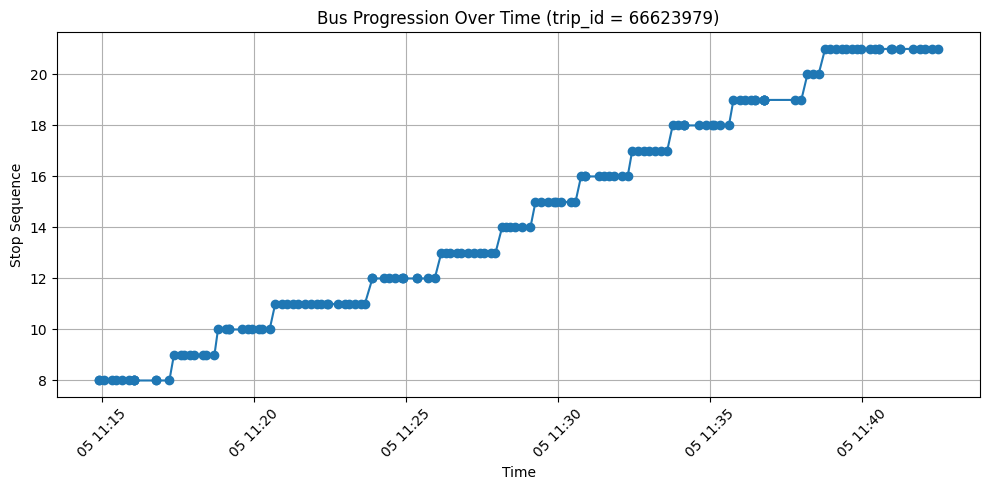

In [17]:
import matplotlib.pyplot as plt

# 選擇一個 trip_id 擁有最多資料點的作為樣本視覺化
sample_trip_id = df['trip_id'].value_counts().idxmax()
trip_df = df[df['trip_id'] == sample_trip_id].sort_values(by='updated_at')

# 繪圖：時間 vs 停靠序號
plt.figure(figsize=(10, 5))
plt.plot(trip_df['updated_at'], trip_df['current_stop_sequence'], marker='o', linestyle='-')
plt.title(f"Bus Progression Over Time (trip_id = {sample_trip_id})")
plt.xlabel("Time")
plt.ylabel("Stop Sequence")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


<h1>Give an estimate of the speed of the bus from current_stop_sequence = 1 to the last  current_stop_sequence. </h1> 

Note: You can use the haversine Python library to calculate the distance between two points, given two longitude and latitude coordinates.

In [18]:
from haversine import haversine

# 計算該 trip 的平均速度（公里 / 小時）
total_distance_km = 0
total_time_hr = 0

trip_df = trip_df.sort_values(by='updated_at').reset_index(drop=True)

for i in range(1, len(trip_df)):
    point1 = (trip_df.loc[i-1, 'latitude'], trip_df.loc[i-1, 'longitude'])
    point2 = (trip_df.loc[i, 'latitude'], trip_df.loc[i, 'longitude'])
    dist = haversine(point1, point2)
    time_diff = (trip_df.loc[i, 'updated_at'] - trip_df.loc[i-1, 'updated_at']).total_seconds() / 3600
    
    total_distance_km += dist
    total_time_hr += time_diff

avg_speed = total_distance_km / total_time_hr if total_time_hr > 0 else 0
print(f"✅ 平均車速（trip_id = {sample_trip_id}）：{avg_speed:.2f} km/h")


✅ 平均車速（trip_id = 66623979）：10.78 km/h
